**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score


from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [3]:
def categorization_comparison_by_target_class(df, TARGET_NAME):
    df_tmp = df.copy()
    col_lst = df_tmp.drop([TARGET_NAME, 'Id'], axis=1).select_dtypes(include=['object', 'int64']).columns
    
    df_tmp['train'] = 1
    df_tmp['train_0'] = df_tmp[TARGET_NAME] * (-1) + 1
    df_tmp['train_1'] = df_tmp[TARGET_NAME]
    
    fig, ax = plt.subplots(nrows=len(col_lst), ncols=1)
    fig.set_size_inches (20 , len(col_lst) * 8)
    ax = ax.flatten()
    
    for i in range(len(col_lst)):
        col = col_lst[i]
        df_comp = df_tmp[[col,'train', 'train_0','train_1']].groupby(by=col).agg({'train':sum, 'train_0':sum,'train_1':sum})
        df_comp['train %'] = round(df_comp['train'] / df_comp['train'].sum() * 100, 2)
        df_comp['train_0 %'] = round(df_comp['train_0'] / df_comp['train_0'].sum() * 100, 2)
        df_comp['train_1 %'] = round(df_comp['train_1'] / df_comp['train_1'].sum() * 100, 2)
        
        print(df_comp[['train', 'train_0','train_1', 'train %', 'train_0 %', 'train_1 %']],'\n')
        
        sns.countplot(x=col, hue=TARGET_NAME, data=df_tmp, ax=ax[i])
        ax[i].set_title('Grouped by "' + TARGET_NAME + '"')
        ax[i].legend(title='Target', loc='upper right')   

In [4]:
def distribution_comparison_by_target_class(df, TARGET_NAME):
    
    col_lst = col_lst = list(df.select_dtypes(include=['float64']).columns)

    fig, ax = plt.subplots(nrows=int((len(col_lst) + 1) // 2), ncols=2)
    fig.set_size_inches (15 , len(col_lst) * 4)
    ax = ax.flatten()
    
    for i in range(len(col_lst)):
        sns.kdeplot(df.loc[df['Credit Default'] == 0, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 0', ax=ax[i])
        sns.kdeplot(df.loc[df['Credit Default'] == 1, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 1', ax=ax[i])
        ax[i].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
        ax[i].legend()

In [5]:
def heatmap(df):
    plt.figure(figsize = (25,20))
    sns.set(font_scale=1.4)
    sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [8]:
def short_model_score_report(y_test, y_test_pred, name):
    print(name, '     f1 score = ', round(f1_score(y_test_pred, y_test),4), '     ' + 'precision =', round(precision_score(y_test_pred, y_test),4), '     '+'recall =', round(recall_score(y_test_pred, y_test),4))

In [9]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [10]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [11]:
def balance_df_by_target(df, TARGET_NAME, portion_of_target_class=0.5, random_state=111):
    df_tmp = df.copy()
    counts_0 = (df_tmp[TARGET_NAME] == 0).sum()
    counts_1 = (df_tmp[TARGET_NAME] == 1).sum()
    minor_class = 0 if (counts_0 < counts_1) else 1
    if portion_of_target_class > (counts_1 / (counts_1 + counts_0)):
        disbalance = int(counts_0 / (1-portion_of_target_class) - counts_1 - counts_0)
    else:
        disbalance = int(counts_1 / (1-portion_of_target_class) - counts_1 - counts_0)
    sample = df_tmp[df_tmp[TARGET_NAME] == minor_class].sample(n=disbalance, replace=True, random_state=random_state)

    return pd.concat([sample, df_tmp], axis=0)

**Пути к директориям и файлам**

In [12]:
# input
train_ds_path = 'D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience 2/pjt/course_project_train_kaggle.csv'
test_ds_path = 'D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience 2/pjt/course_project_test_kaggle.csv'

# output
output_ds_path = 'D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience 2/pjt/AUshakov_predictions.csv'
output_ds_path_kaggel = 'D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience 2/pjt/pjt_sub_kaggel.csv'

In [14]:
# Загрузка данных
df = pd.read_csv(train_ds_path)
df_test = pd.read_csv(test_ds_path)
TARGET_NAME = "Credit Default"
df_for_stat = pd.concat([df.drop(TARGET_NAME, axis=1), df_test], axis=0)


**Исследование данных**

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

In [16]:
df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


                train  train_0  train_1  train %  train_0 %  train_1 %
Home Ownership                                                        
Have Mortgage      12       10        2     0.16       0.19       0.09
Home Mortgage    3637     2721      916    48.49      50.51      43.35
Own Home          647      455      192     8.63       8.45       9.09
Rent             3204     2201     1003    42.72      40.86      47.47 

                      train  train_0  train_1  train %  train_0 %  train_1 %
Years in current job                                                        
1 year                  504      362      142     7.07       7.03       7.19
10+ years              2332     1688      644    32.71      32.76      32.59
2 years                 705      512      193     9.89       9.94       9.77
3 years                 620      450      170     8.70       8.73       8.60
4 years                 469      338      131     6.58       6.56       6.63
5 years                 516      

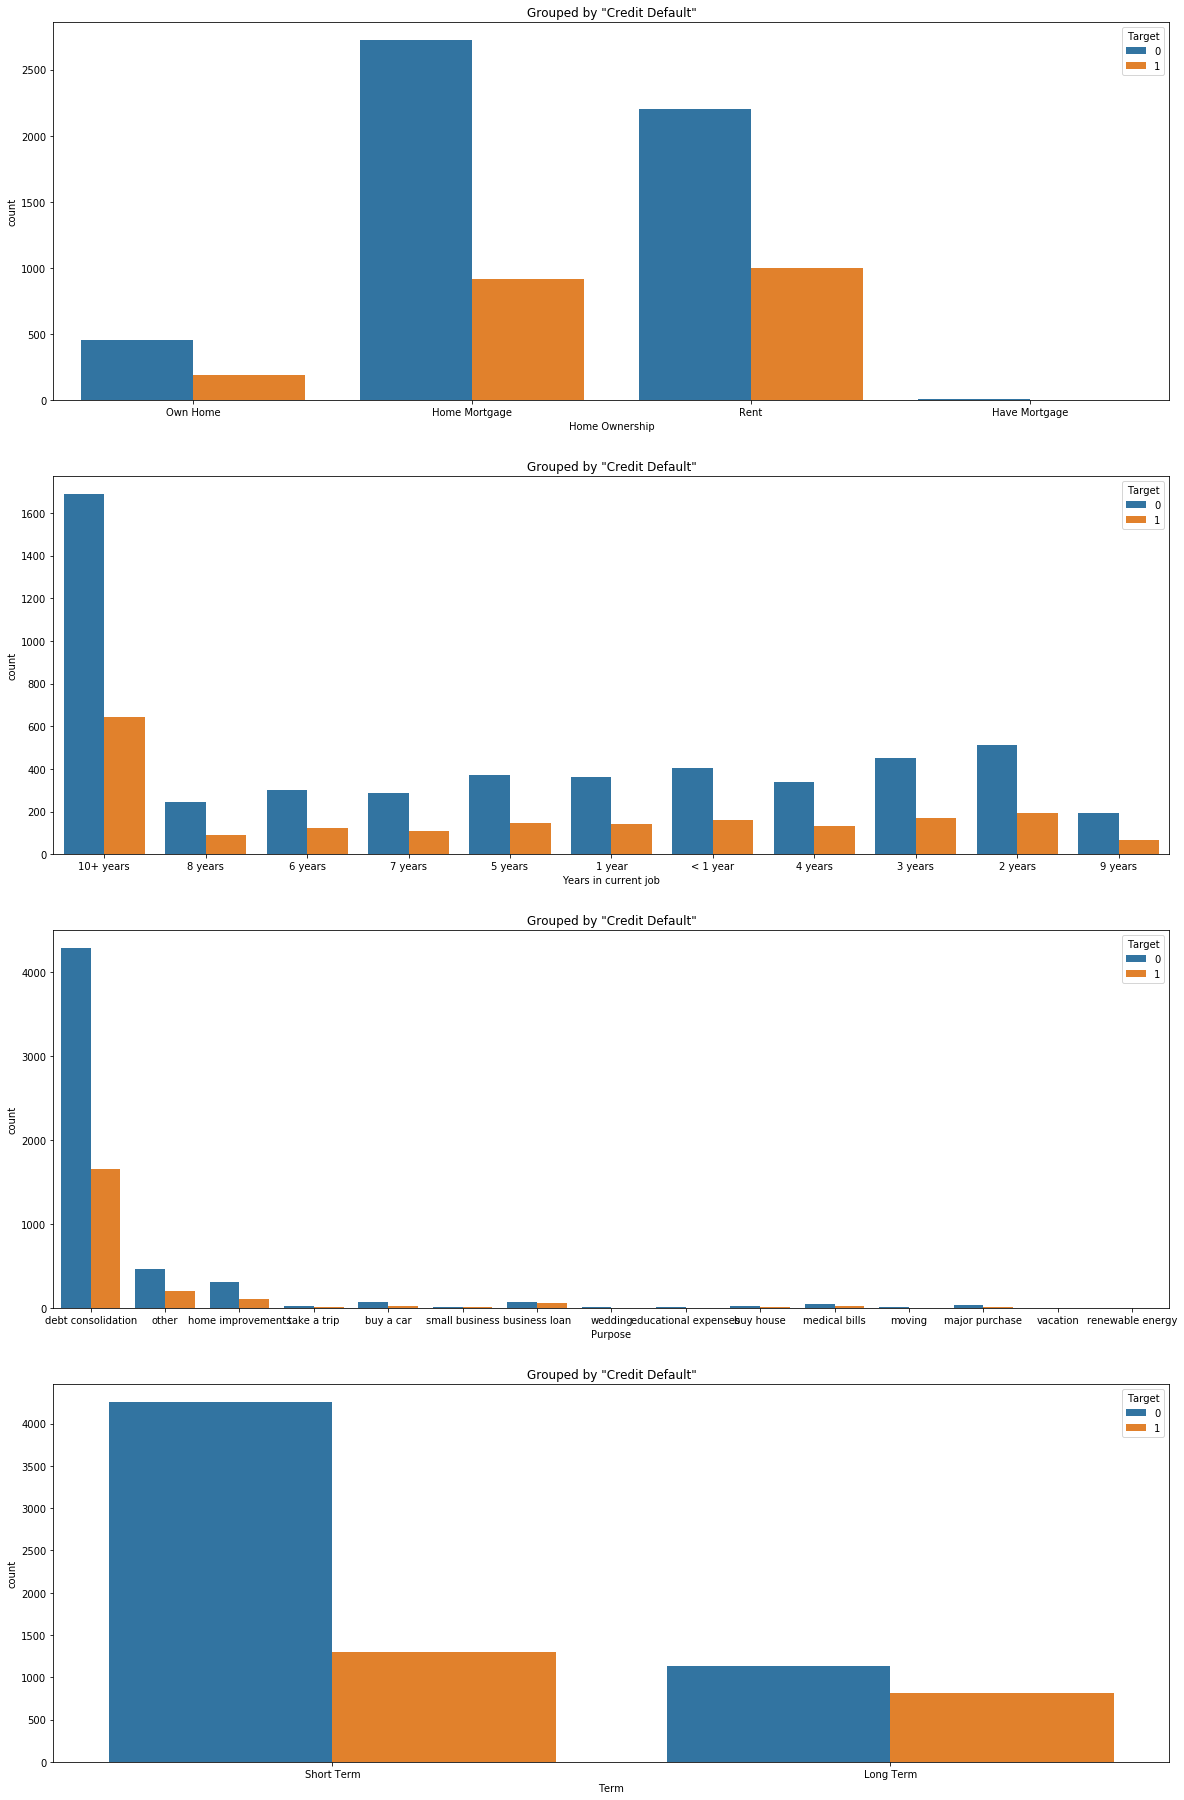

In [18]:
categorization_comparison_by_target_class(df, TARGET_NAME)

In [19]:
# функция обработки данных
def data_processing(df_to_process, df_for_stat):
    tmp_df = df_to_process.copy()
    
    #Обработка пропусков
    tmp_df['Income data'] = tmp_df['Annual Income'] > 0
    tmp_df['Credit Score 6000+'] = tmp_df['Credit Score'] > 6000
    tmp_df.loc[tmp_df['Credit Score'] > 6000,'Credit Score'] = float("NaN")
    tmp_df['Credit Score data'] = tmp_df['Credit Score'] > 0
    tmp_df.loc[tmp_df['Income data'] == False, 'Annual Income'] = tmp_df['Annual Income'].mean()  
    tmp_df.loc[tmp_df['Bankruptcies'].isnull(),'Bankruptcies'] = 0
    
    tmp_df.loc[tmp_df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 75 # равновероятное значения по целевому классу
    
    #Обработка выбросов
    tmp_df['99999999'] = tmp_df['Current Loan Amount'] == 99999999
    tmp_df.loc[tmp_df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0
    
    for col in ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance']:
        max_col_value = tmp_df[col].quantile(q=0.75) + (tmp_df[col].quantile(q=0.75) - tmp_df[col].quantile(q=0.25))*1.5
        min_col_value = tmp_df[col].quantile(q=0.25) - (tmp_df[col].quantile(q=0.75) - tmp_df[col].quantile(q=0.25))*1.5
        tmp_df.loc[(df[col] > max_col_value) | (tmp_df[col] < min_col_value), col] = tmp_df[col].mean()
    
    
    #Работа с Dummy переменными
    tmp_df['Long Term'] = (tmp_df['Term'] == 'Long Term')
    tmp_df = tmp_df.drop(['Term'], axis=1)
    tmp_df.loc[tmp_df['Years in current job']=='< 1 year', 'Years in current job'] = 'below 1 year'
    
    tmp_df = pd.get_dummies(tmp_df)
    
    
    #Удаление/объединение признаков
    if 'Purpose_renewable energy' in tmp_df.columns:
        tmp_df.drop(['Purpose_renewable energy'], axis=1, inplace=True) # не имеет смысла, т.к. занчение не повторятся в тестовой выборке
        
    #Построение новых признаков
    tmp_df['Loan_income_ratio'] =  tmp_df['Current Loan Amount'] / tmp_df['Annual Income']
    tmp_df['Balance_income_ratio'] =  tmp_df['Current Credit Balance'] / tmp_df['Annual Income']
    tmp_df['Debt_income_ratio'] =  tmp_df['Monthly Debt'] / tmp_df['Annual Income']
        
    return tmp_df
#data_processing(df, df).info()

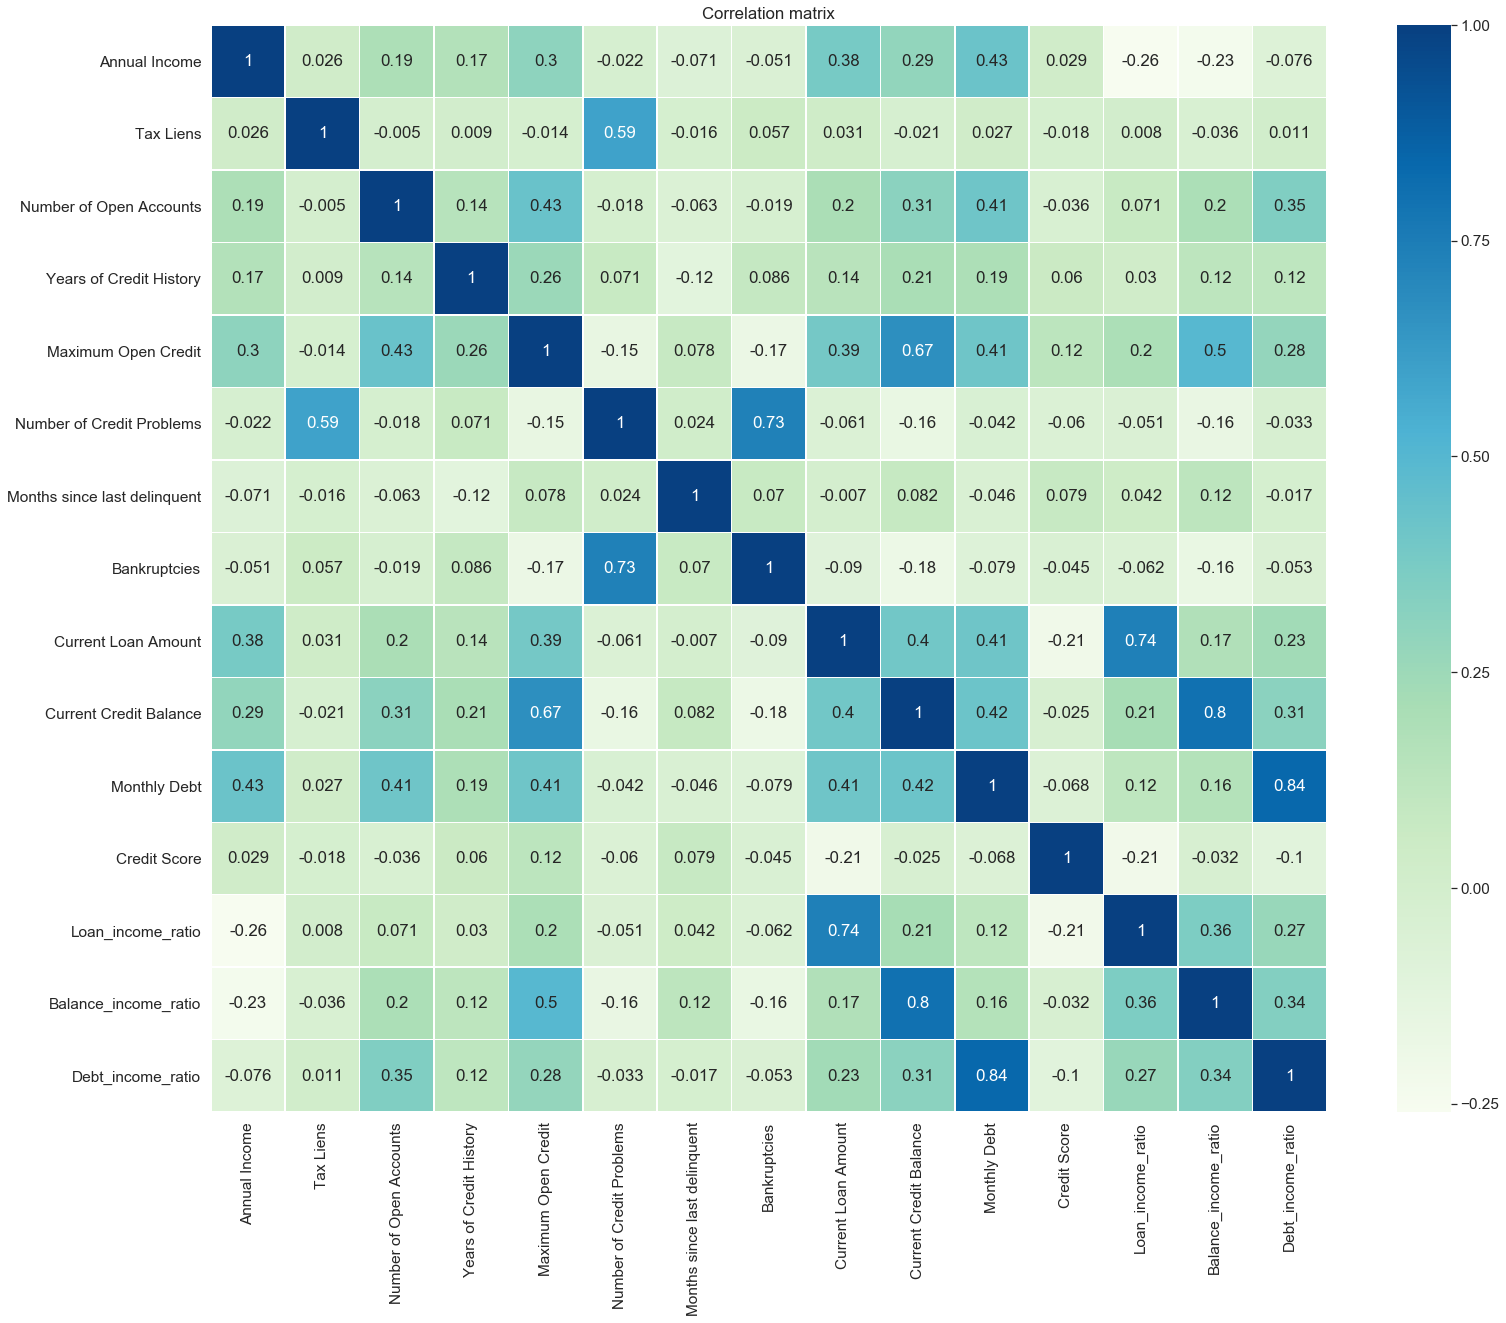

In [20]:
heatmap(data_processing(df, df).select_dtypes('float64'))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


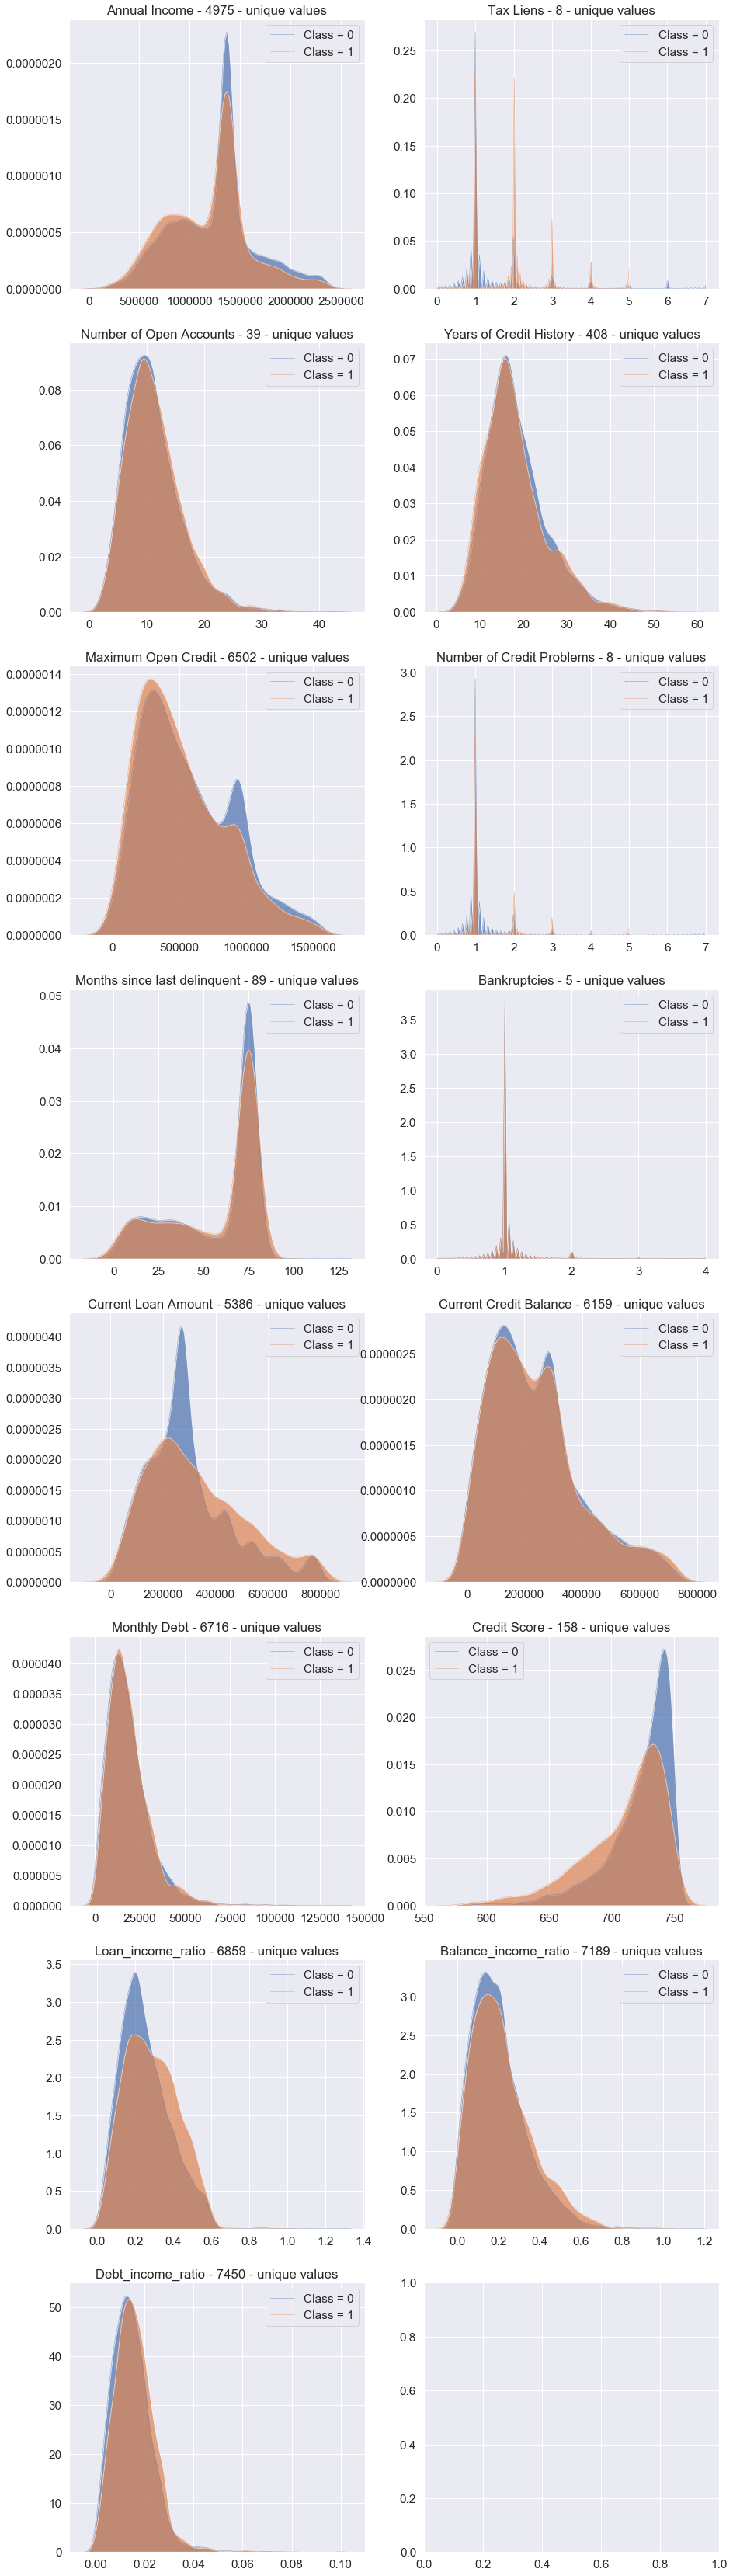

In [21]:
distribution_comparison_by_target_class(data_processing(df, df), TARGET_NAME)

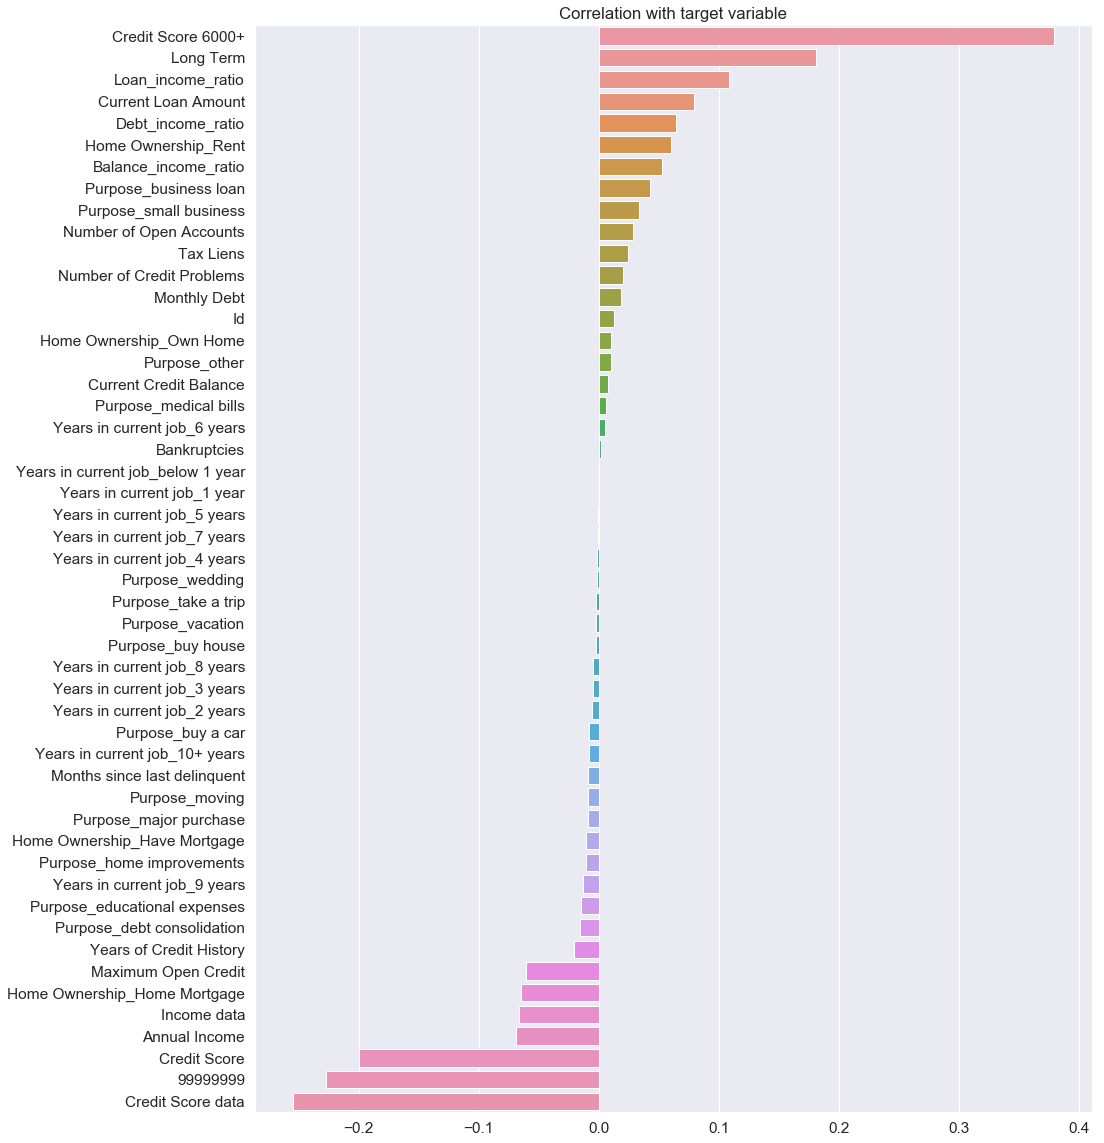

In [22]:
df_tmp = data_processing(df, df)
corr_with_target = df_tmp.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

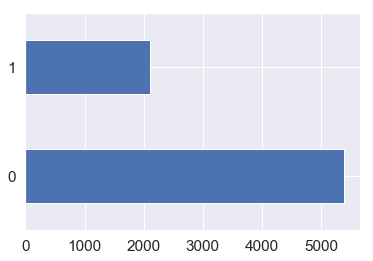

In [23]:
df[TARGET_NAME].value_counts().plot.barh()

**Построение моеделей и результат голосования**

In [24]:
#CATB
model_catb = catb.CatBoostClassifier(n_estimators=1000,
                                     max_depth=3,
                                     silent=True,
                                     random_state=21)
#LGBM
model_lgbm = lgbm.LGBMClassifier(n_estimators=50,
                                 metric='f1',
                                 num_leaves=10,
                                 min_data_in_leaf=35,
                                 learning_rate=0.1,
                                 num_threads=4,
                                 random_state=42)
#XGBOOST
model_xgb = xgb.XGBClassifier(silent=False, 
                              nthread=-1, 
                              max_depth=3, 
                              n_estimators=2500, 
                              subsample=0.5, 
                              learning_rate=0.005, 
                              random_state=42)

In [ ]:
%%time
#Обработка данных
df_tmp = data_processing(df, df)
df_test_tmp = data_processing(df_test, df_test)
df_test_result = pd.DataFrame({'Id': df_test_tmp['Id']})

X = df_tmp.drop(TARGET_NAME, axis=1)
y = df_tmp[TARGET_NAME]

#Разбивка на test и train 
i = 0
kf = KFold(n_splits=4, shuffle=True, random_state=42)
for train_index, test_index in kf.split(df_tmp):
    i += 1
    X_train, X_test = X.loc[list(train_index)], X.loc[list(test_index)]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    #Балансировка по целевому классу
    df_balanced = balance_df_by_target(pd.concat([X_train, y_train], axis=1), TARGET_NAME, 0.48, 2)
    X_train = df_balanced.drop(columns=TARGET_NAME)
    y_train = df_balanced[TARGET_NAME]
    
    model_catb.fit(X_train, y_train)
    model_lgbm.fit(X_train, y_train)
    model_xgb.fit(X_train, y_train)
    
    print('\nFOLD ' + str(i) + ' REPORT\n'+'*'*75)
    short_model_score_report(model_catb.predict(X_test), y_test, 'catb_'+str(i))
    short_model_score_report(model_lgbm.predict(X_test), y_test, 'lgbm_'+str(i))
    short_model_score_report(model_xgb.predict(X_test), y_test, 'xgbm_'+str(i))
    
    # Формирование датасета с результатом работы моделей для голосования
    df_test_result['catb_'+str(i)] = model_catb.predict(df_test_tmp).astype('int')
    df_test_result['lgbm_'+str(i)] = model_lgbm.predict(df_test_tmp)
    df_test_result['xgbm_'+str(i)] = model_xgb.predict(df_test_tmp)
    #Построение прогноза и сохранение в файл

#Выгрузка результатов голосования моделей в фаил
pd.DataFrame({'Credit Default': round((df_test_result.iloc[:,1:].sum(axis=1)+1)/16,0).astype('int')
             }).to_csv(output_ds_path, index=False)

**Построение одиночных модели**

In [26]:
#Обработка данных
df_tmp = data_processing(df, df)
df_test_tmp = data_processing(df_test, df_test)


#Разбивка на test и train
X = df_tmp.drop(TARGET_NAME, axis=1)
y = df_tmp[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

#Балансировка по целевому классу
df_balanced = balance_df_by_target(pd.concat([X_train, y_train], axis=1), TARGET_NAME, 0.50, 2)
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      4074
           1       0.78      0.78      0.78      4074

   micro avg       0.78      0.78      0.78      8148
   macro avg       0.78      0.78      0.78      8148
weighted avg       0.78      0.78      0.78      8148

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.77      1313
           1       0.50      0.65      0.57       562

   micro avg       0.70      0.70      0.70      1875
   macro avg       0.67      0.69      0.67      1875
weighted avg       0.73      0.70      0.71      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               956  357
1               199  363


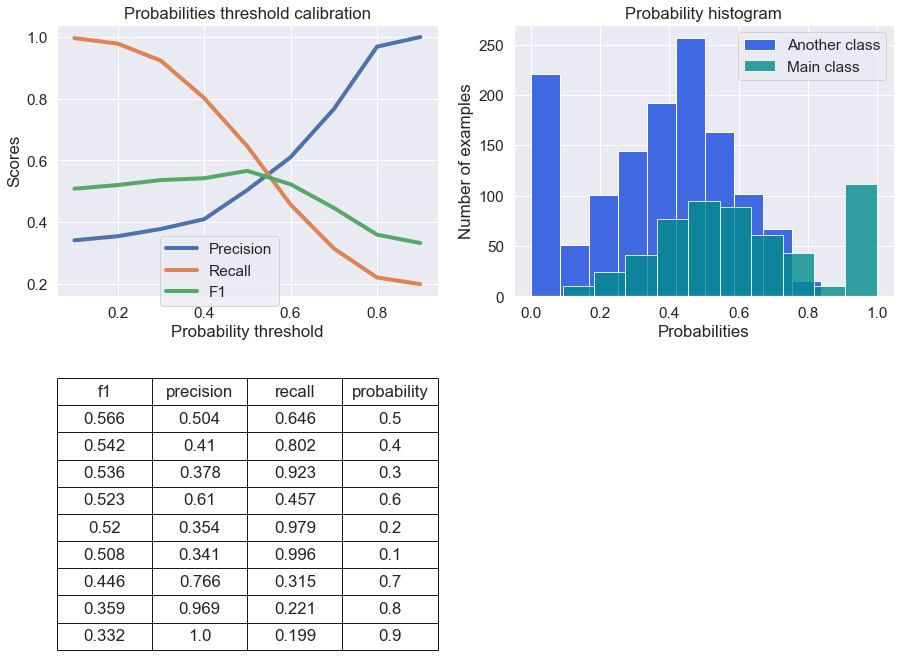

Wall time: 22.5 s


In [27]:
%%time

df_tmp = data_processing(df, df)
df_test_tmp = data_processing(df_test, df_test)

model_catb = catb.CatBoostClassifier(n_estimators=1000, max_depth=3, silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [28]:
#Построение прогноза и сохранение в файл
pd.DataFrame({'Id': df_test_tmp['Id'],
              'Credit Default': model_catb.predict(df_test_tmp).astype('int')
             }).to_csv(output_ds_path_kaggel, index=False)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      4074
           1       0.76      0.75      0.76      4074

   micro avg       0.76      0.76      0.76      8148
   macro avg       0.76      0.76      0.76      8148
weighted avg       0.76      0.76      0.76      8148

TEST

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1313
           1       0.49      0.63      0.55       562

   micro avg       0.69      0.69      0.69      1875
   macro avg       0.65      0.67      0.66      1875
weighted avg       0.72      0.69      0.70      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               943  370
1               209  353


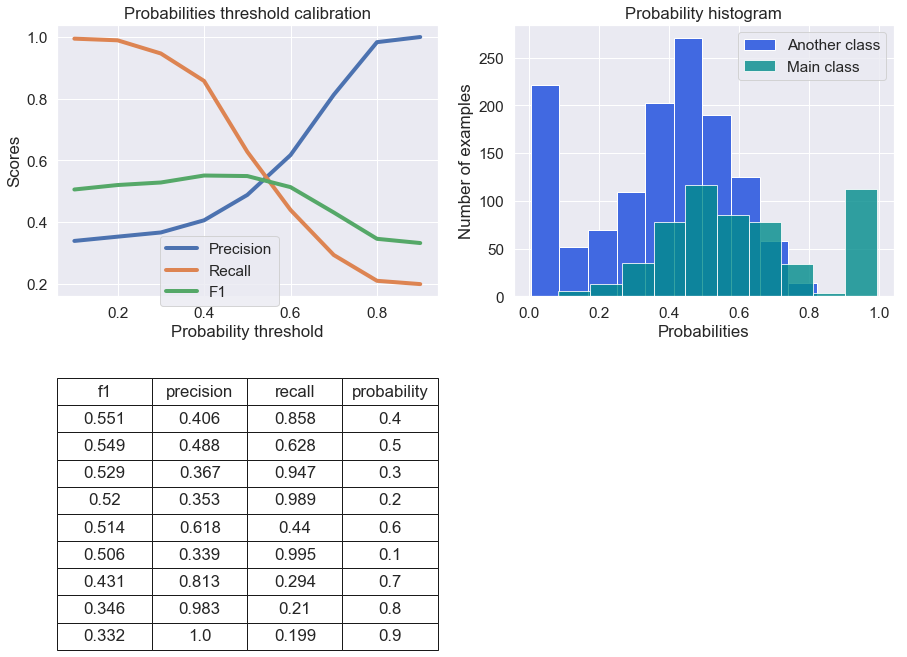

In [29]:
# LGB model

model_lgbm = lgbm.LGBMClassifier(n_estimators=50, metric='f1', num_leaves=10, min_data_in_leaf=35, learning_rate=0.1, num_threads=4, random_state=42)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)
y_test_pred_probs = model_lgbm.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [30]:
#Построение прогноза и сохранение в файл
pd.DataFrame({'Id': df_test_tmp['Id'],
              'Credit Default': model_lgbm.predict(df_test_tmp).astype('int')
             }).to_csv(output_ds_path_kaggel, index=False)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      4074
           1       0.78      0.78      0.78      4074

   micro avg       0.78      0.78      0.78      8148
   macro avg       0.78      0.78      0.78      8148
weighted avg       0.78      0.78      0.78      8148

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.77      1313
           1       0.50      0.65      0.57       562

   micro avg       0.70      0.70      0.70      1875
   macro avg       0.67      0.69      0.67      1875
weighted avg       0.73      0.70      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               952  361
1               196  366


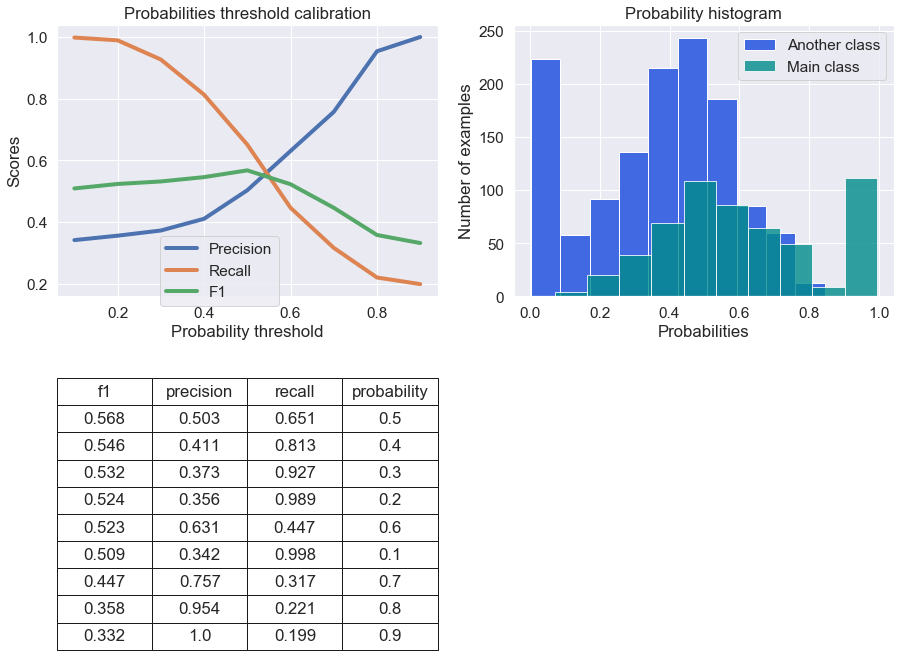

In [31]:
# XGB model
model_xgb = xgb.XGBClassifier(silent=False, nthread=-1, max_depth=3, n_estimators=2500, subsample=0.5, learning_rate=0.005, random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)
y_test_pred_probs = model_xgb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [32]:
#Построение прогноза и сохранение в файл
pd.DataFrame({'Id': df_test_tmp['Id'],
              'Credit Default': model_xgb.predict(df_test_tmp).astype('int')
             }).to_csv(output_ds_path_kaggel, index=False)

**ВЫВОД**

In [ ]:
Наилучший результат на keggle показала модель CATB f1=0.541
При этом наиболее учтойчивый резултат относительно Random_State показывает голосование различных моделей



**НАРАБОТКИ**

In [ ]:
#Нормализация данных - С ДЕРЕВЬЯМИ МОЖНО БЕЗ НОРМАЛИЩЗАЦИИ - ПОКАЗЫВАЕТ РЕЗУЛЬТАТ ХУЖЕ
NUMERIC_FEATURES = df_tmp.select_dtypes(include='float64').columns
scaler = StandardScaler()
df_tmp[NUMERIC_FEATURES] = scaler.fit_transform(df_tmp[NUMERIC_FEATURES])
df_test_tmp[NUMERIC_FEATURES] = scaler.transform(df_test_tmp[NUMERIC_FEATURES])

In [ ]:
# Подбор оптимальных мараметров - приводит к серьезному переобучению
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
params = {'n_estimators':[300, 500, 1000], 
          'max_depth':[3, 2, 4],
          'learning_rate':[0.05, 0.1, 0.2]}
cv=KFold(n_splits=3, random_state=21, shuffle=True)
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_

In [ ]:
rs.best_params_

In [ ]:
#Проверка на случай несовпадения столбцов
if df_balanced.drop(columns=TARGET_NAME).shape[1] != df_test_tmp.shape[1] or (df_balanced.drop([TARGET_NAME], axis=1).columns != df_test_tmp.columns).all():
    print("НЕ ВСЕ СТОЛБЦЫ СОВПАДАЮТ")
    for i in range(len(X_train.columns.tolist())):
        print(X_train.columns.tolist()[i] == df_test_tmp.columns.tolist()[i],  X_train.columns.tolist()[i] , ' -----',df_test_tmp.columns.tolist()[i])

In [ ]:
#Прогнозирование "Credit Score" - НЕ РАБОТАЕТ
df_tmp = data_processing(df, df)
df_test_tmp = data_processing(df_test, df_test)


#Разбивка на test и train
X = df_tmp.drop([TARGET_NAME, 'Credit Score'], axis=1)
y = df_tmp['Credit Score']
X = X.loc[y.isnull()==False]
y = y.loc[y.isnull()==False]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

model_catb_r = catb.CatBoostRegressor(n_estimators=1000,
                                     max_depth=4,
                                     silent=True,
                                     random_state=42)

model_catb_r.fit(X_train, y_train)
print(round(r2_score(y_test, model_catb_r.predict(X_test)),4), round(r2_score(y_train, model_catb_r.predict(X_train)),4))

X = df_tmp.loc[df_tmp['Credit Score'].isnull()].drop([TARGET_NAME, 'Credit Score'], axis=1)
df_tmp.loc[df_tmp['Credit Score'].isnull(), 'Credit Score'] = model_catb_r.predict(X)

X = df_test_tmp.loc[df_test_tmp['Credit Score'].isnull()].drop(['Credit Score'], axis=1)
df_test_tmp.loc[df_test_tmp['Credit Score'].isnull(), 'Credit Score'] = model_catb_r.predict(X)